# VelocityHack
Swung London Hackathon
1st-2nd June 2019

Well logs here:
https://certmapper.cr.usgs.gov/data/PubArchives/of00-200/wells/AWUNA1/LAS/AW1LAS.HTM

In [1]:
import lasio
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
import plotting as p
import velocity as v

In [3]:
%load_ext autoreload
%autoreload 2

#### Load LAS Data

In [4]:
log = lasio.read('data/GN3.las')

Header section Parameter regexp=~P was not found.


In [5]:
# show the log header and data available
log.header

{'Version': [HeaderItem(mnemonic=VERS, unit=, value=2.0, descr=CWLS LOG ASCII STANDARD -V...),
  HeaderItem(mnemonic=WRAP, unit=, value=NO, descr=ONE LINE PER DEPTH STEP)],
 'Well': [HeaderItem(mnemonic=STRT, unit=m, value=8.9916, descr=START DEPTH),
  HeaderItem(mnemonic=STEP, unit=m, value=0.1524, descr=STEP DEPTH),
  HeaderItem(mnemonic=STOP, unit=m, value=2706.1668, descr=STOP DEPTH),
  HeaderItem(mnemonic=NULL, unit=, value=-999.25, descr=NULL VALUE),
  HeaderItem(mnemonic=COMP, unit=, value=, descr=COMPANY),
  HeaderItem(mnemonic=WELL, unit=, value=, descr=WELL),
  HeaderItem(mnemonic=LOC, unit=, value=, descr=LOCATION - AREA),
  HeaderItem(mnemonic=FLD, unit=, value=, descr=FIELD),
  HeaderItem(mnemonic=CTRY, unit=, value=, descr=COUNTRY),
  HeaderItem(mnemonic=DATE, unit=, value=, descr=WELL DATE),
  HeaderItem(mnemonic=XWELL, unit=m, value=, descr=X POS),
  HeaderItem(mnemonic=YWELL, unit=m, value=, descr=Y POS),
  HeaderItem(mnemonic=EDF, unit=, value=6.1, descr=DERRICK FLOOR

In [6]:
df_log = log.df()
df_log = df_log[['VP']].dropna()

depth = df_log.index.values.reshape(-1,1)
vel = df_log['VP'].values.reshape(-1,1)

# convert from km/s to m/s
vel = vel*1000

# todo DTC microseconds/feet (instantenous travel time) to velocity conversion
# 1 mil / DTC / 3.281

#### Plot Velocity Log

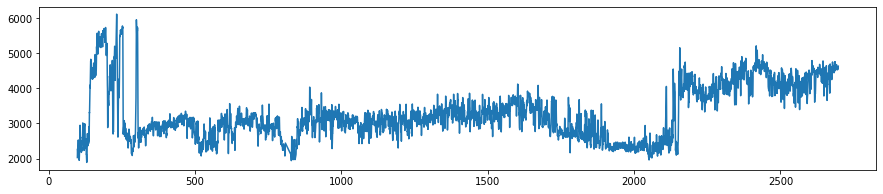

In [7]:
plt.figure(figsize=(15, 3))
plt.plot(depth, vel)
plt.show()

In [8]:
from ipywidgets import interactive, IntRangeSlider, IntSlider, fixed

In [9]:
# todo smoothing slider, two logs on top of each other

slider = IntRangeSlider(min=depth.min(), max=depth.max(), step=1.)

interactive_plot = interactive(p.plot_log, slider_range=slider, depth=fixed(depth), vp=fixed(vel))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntRangeSlider(value=(748, 2047), description='slider_range', max=2697, min=98), Output(…

In [10]:
# get values from slider
depth_min = slider.value[0]
depth_max = slider.value[1]
print(depth_min, depth_max)
depth_idx = p.filter_depth(depth, depth_min, depth_max)

# filter values
depth = depth[depth_idx].reshape(-1, 1)
vel = vel[depth_idx].reshape(-1, 1)

1100 1600


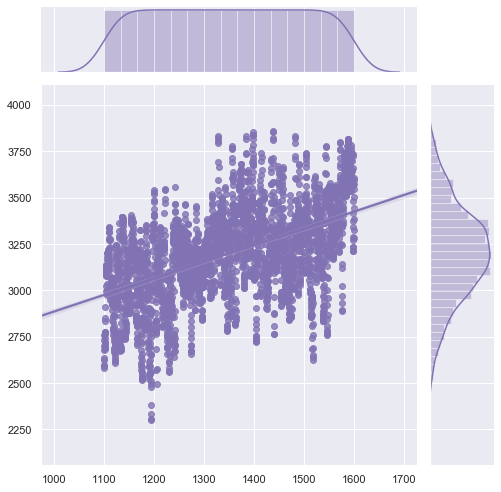

In [11]:
import seaborn as sns
sns.set(style="darkgrid")

g = sns.jointplot(depth, vel, kind="reg", color="m", height=7)

# Simulating pairs of K and V0 

In [12]:
# simulate velocities

k, v0, pred_vel, rmse = v.simulate_linear_velocity(depth, vel, nr_samples=100000)

In [13]:
def plot_rmse_ellipse(ax, k, v0, rmse, cutoff=500):

    # lowest rmse indices
    idx = rmse.argsort()[:cutoff]
    # best fit point
    idx_min = rmse.argmin()

    sc = ax.scatter(k[idx], v0[idx], c=rmse[idx], s=10)
    ax.scatter(k[idx_min], v0[idx_min], c='yellow', s=100, marker='X')
    # plt.colorbar()
    return sc, idx, idx_min


In [23]:
%matplotlib inline
from ipywidgets import interactive, FloatRangeSlider, FloatSlider, IntSlider

def f(max_rmse):
    fig, ax = plt.subplots(1, 2, figsize=(15, 3))
    n_show = 10
    sc, idx, idx_min = p.plot_rmse_ellipse(ax[0], k[::n_show], v0[::n_show], rmse[::n_show], max_rmse)
    ax[1].hist(rmse)
    ax[1].axvline(max_rmse, color="black", linestyle="--")


rmse_slider = IntSlider(min=int(rmse.min()), max=np.quantile(rmse, 0.25), step=10., continuous_update=False)
rmse_plot = interactive(f, max_rmse=rmse_slider)

rmse_output = rmse_plot.children[-1]
rmse_output.layout.height = '350px'
rmse_plot

interactive(children=(IntSlider(value=214, continuous_update=False, description='max_rmse', max=1063, min=214,…

In [19]:
# # get the indexes for the best rmse values

low_rmse_idx = rmse.argsort()[:cutoff]
med_rmse_idx = rmse.argsort()[cutoff:cutoff*2]
high_rmse_idx = rmse.argsort()[cutoff*2:cutoff*3]

NameError: name 'idx_min' is not defined

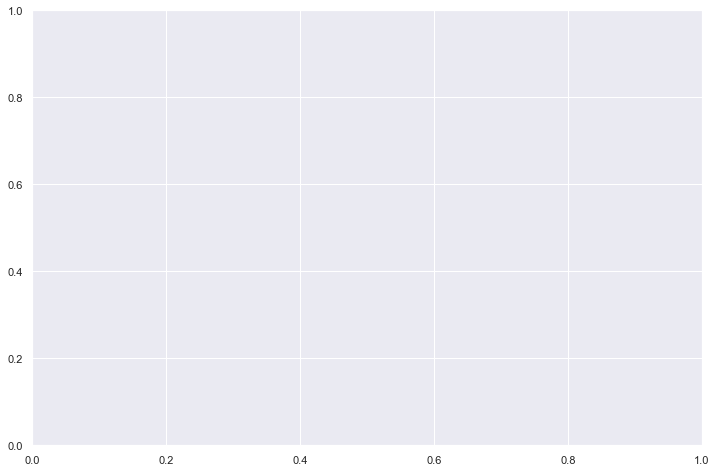

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
nr_samples = 10
lp, sample_rmse_idx = p.plot_velocity_predictions(ax, depth, vel, pred_vel, rmse, idx_min, cutoff, nr_samples)

In [29]:
df_output = pd.DataFrame(zip(v0[sample_rmse_idx], k[sample_rmse_idx], rmse[sample_rmse_idx]), columns=['v0','k','rmse'])
df_output

,v0,k,rmse
0,1707.895480,1.088075,222.414542
1,1861.832177,1.020949,223.329950
2,2282.624656,0.696587,221.965301
3,1501.640857,1.245639,225.853304
4,1546.308728,1.217663,224.542867
5,2195.373560,0.778832,224.126694
6,2374.722762,0.613847,223.070364
7,2043.830876,0.821396,225.193193
8,1860.094643,0.958520,224.628999
9,1623.609892,1.176688,223.404168


In [30]:
#todo rename index
df_output.to_csv('data/output_k_v0_pairs.csv')

## Clustering 

In [153]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

In [125]:
#df = gn3.df()[['VP','VS','RHOB','CGR','VWCL','PHIT']].dropna()
df = gn3.df()[['VP','VS','RHOB']].dropna()

In [126]:
df = df.rolling(100, min_periods=1).median()

In [127]:
df.count()

VP      16780
VS      16780
RHOB    16780
dtype: int64

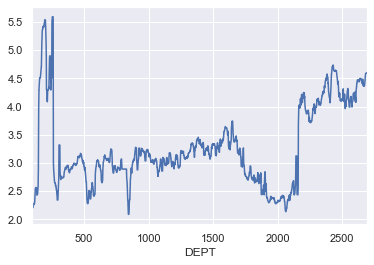

In [128]:
df['VP'].plot()

In [129]:
X = df.reset_index().values
#X = df.values

In [130]:
from sklearn.preprocessing import MinMaxScaler

In [131]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [118]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_scaled)

In [119]:
kmeans.labels_

array([0, 0, 0, ..., 1, 1, 1])

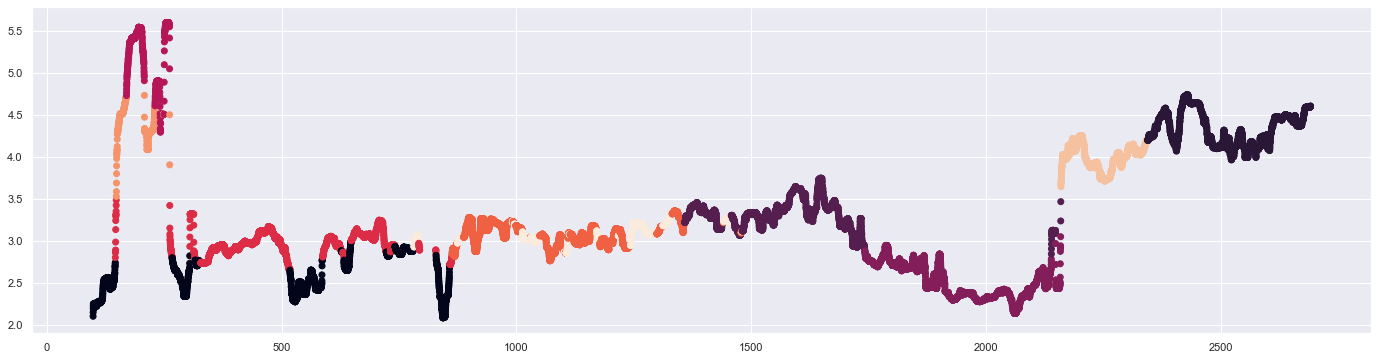

In [120]:
fig, ax = plt.subplots(1,1, figsize=(24,6))
plt.scatter(df.index, df['VP'], c=kmeans.labels_)

In [200]:
dbscan = DBSCAN(eps=0.4).fit(X)

In [201]:
dbscan.labels_

array([ 0,  0,  0, ..., 10, 10, 10], dtype=int64)

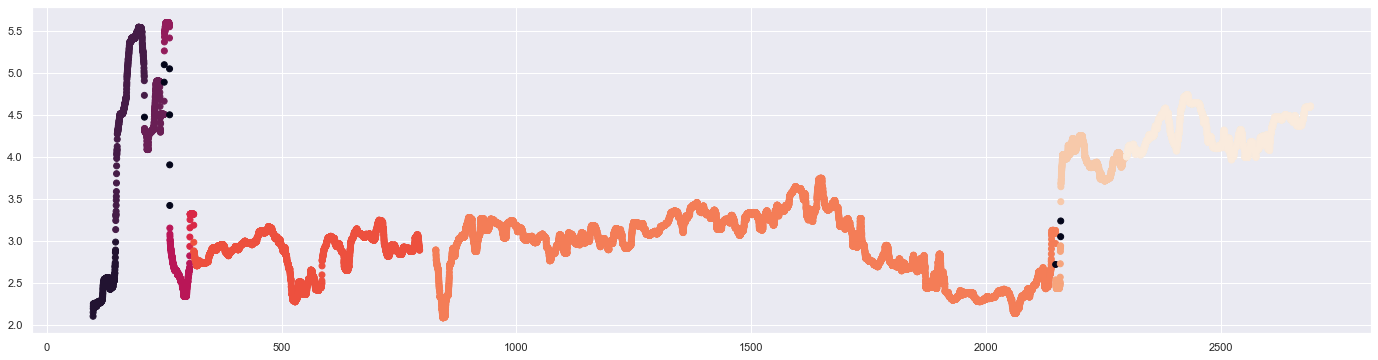

In [202]:
fig, ax = plt.subplots(1,1, figsize=(24,6))
plt.scatter(df.index, df['VP'], c=dbscan.labels_)

In [206]:
gmm = GaussianMixture(n_components=15).fit(X)

In [207]:
X_pred = gmm.predict(X)
X_pred

array([ 2,  2,  2, ..., 12, 12, 12], dtype=int64)

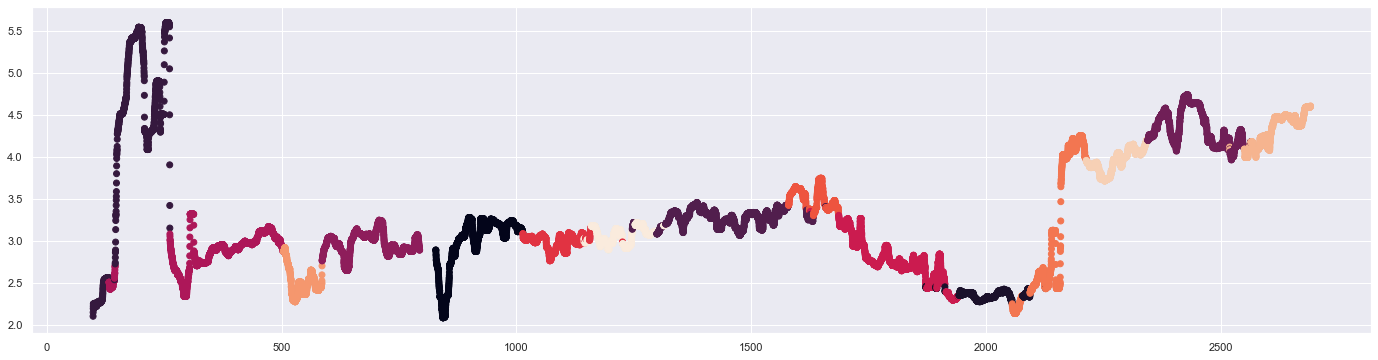

In [208]:
fig, ax = plt.subplots(1,1, figsize=(24,6))
plt.scatter(df.index, df['VP'], c=X_pred)

# Todo

* Getting to an automated low, mid, high structure model, structure volume 
* Interactive visualisation for a given V0 or K combination

## potential

* Bayesian modelling, sampling - Uncertainty quantification
* Clustering picking of formations using Gaussian Mixture Models etc..
* Run the lin_velocity function on multiple wells and formations find low error ranges for V0 and K